# Zhang 2023 Upper Bound Temperature
This looks at applying the theory from Byrne 2023 but to an aquaplanet.

Looks at how the hottest days compare to the theoretical upper bound temperature for a given the 500hPa temperature.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy.stats import percentileofscore

2023-03-27 16:17:11,320 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
# only keep variables required to compute relative humidity, MSE and miyawaki R1 value
var_keep = ['temp', 'sphum', 'vcomp', 'ucomp', 'height', 'precipitation']
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset, `ds_lat`, for each latitude bin containing surface and free troposphere data for that latitude range.

In [3]:
# Get data set averaged over all summer days considering in each latitude bin.
# Do this for each optical depth value
use_time_start = 360*2
pressure_ft = 500

ds_use = ds[0].sel(time=slice(use_time_start, np.inf), drop=True)[var_keep]
ds_use = ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest', drop=True).load()
z_ft_mean = float(area_weighting(ds_use.height[:, 0]).mean())
temp_ft_mean = float(area_weighting(ds_use.temp[:, 0]).mean())
pressure_ft_actual = float(ds_use.pfull[0])        # actual free troposphere pressure in hPa
pressure_surface = float(ds_use.pfull[1])          # surface pressure in hPa

In [4]:
temp_bins = np.linspace(ds_use.temp[:, 0].min(), ds_use.temp[:, 0].max(), 20)
z_bins = np.linspace(ds_use.height[:, 0].min(), ds_use.height[:, 0].max(), 20)
hist = np.histogram2d(ds_use.temp[:, 0].to_numpy().flatten(), ds_use.height[:, 0].to_numpy().flatten(), bins=[temp_bins, z_bins])[0]

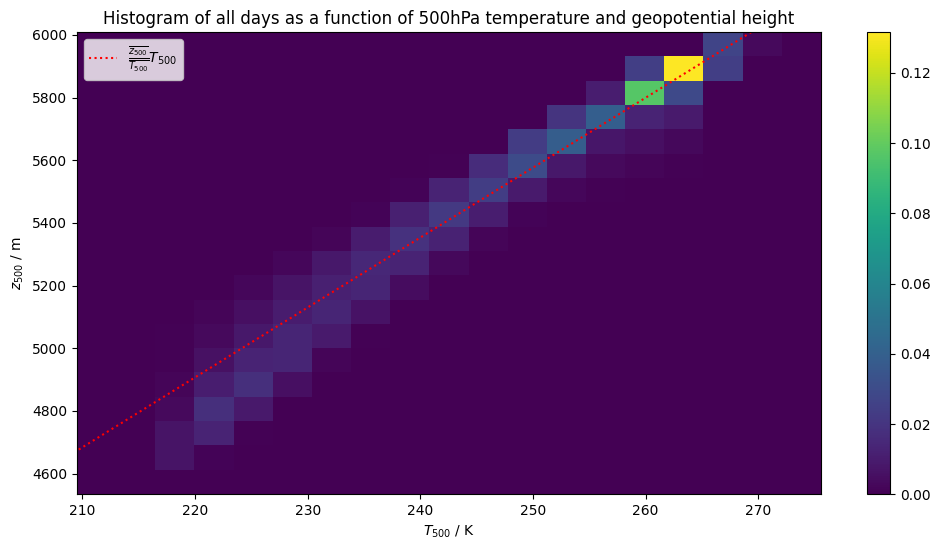

In [5]:
# Check that z_ft vs temp_ft relationship is approximately valid
temp_ft_array = np.arange(200, 300)
fig, ax = plt.subplots(1,1, figsize=(12, 6))
im = plt.imshow(hist.T/hist.sum(), origin='lower', aspect='auto', extent=[temp_bins[0], temp_bins[-1], z_bins[0], z_bins[-1]])
fig.colorbar(im)
ax.plot(temp_ft_array, (z_ft_mean/temp_ft_mean * temp_ft_array), color='r', linestyle=':',
        label='$\\frac{\overline{z_{500}}}{\overline{T_{500}}} T_{500}$')
ax.set_ylabel(f"$z_{'{'+str(pressure_ft)+'}'}$ / m")
ax.set_xlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
ax.set_title(f'Histogram of all days as a function of {pressure_ft}hPa temperature and geopotential height')
ax.legend()
ax.set_xlim(temp_bins[0], temp_bins[-1])
ax.set_ylim(z_bins[0], z_bins[-1]);

## Figures 3B, 3C
The vorticity used is manually computed, rather than using that outputted from Isca, so may not be particularly useful.

In [6]:
# Compute free troposphere vorticity at each time, lon and lat
cos_lat = np.cos(np.deg2rad(ds_use.lat)).to_numpy().reshape(1, -1, 1)
np.gradient(ds_use.vcomp[:, 0], np.deg2rad(ds_use.lon), axis=2)
np.gradient(ds_use.ucomp[:, 0] * cos_lat, np.deg2rad(ds_use.lat), axis=1)
vorticity = (np.gradient(ds_use.vcomp[:, 0], np.deg2rad(ds_use.lon), axis=2) -
             np.gradient(ds_use.ucomp[:, 0] * cos_lat, np.deg2rad(ds_use.lat), axis=1)) / (radius_earth * cos_lat)
vorticity = xr.DataArray(vorticity, coords=ds_use.temp[:,0].coords)

In [7]:
# Compute theoretical upper bound on temperature if completely dry surface
def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1 + w_sat)
    return q_sat

temp_upper_bound = temp_ft_array + L_v/c_p * sphum_sat(temp_ft_array, pressure_ft_actual * 100) + \
                   g/c_p * z_ft_mean/temp_ft_mean * temp_ft_array

In [8]:
quant_plot = 90                 # show top 10 percentile temp in plots
lat_min = [0, 40, 70]
lat_max = [20, 65, 90]
n_lat = len(lat_min)
ds_lat = []
vorticity_lat = []
quant_thresh = np.zeros(n_lat)
with tqdm(total=n_lat, position=0, leave=True) as pbar:
    for i in range(n_lat):
        ds_use2 = ds_use.where((np.abs(ds_use.lat)<=lat_max[i]) & (np.abs(ds_use.lat)>=lat_min[i]), drop=True)
        ds_use2 = ds_use2[['temp', 'sphum', 'height']]      # Only keep min required variables
        vorticity2 = vorticity.where((np.abs(ds_use.lat)<=lat_max[i]) & (np.abs(ds_use.lat)>=lat_min[i]), drop=True)

        quant_thresh[i] = ds_use2.temp[:, -1].quantile(quant_plot/100, dim=['time', 'lat', 'lon'])
        keep = ds_use2.temp[:, -1] > quant_thresh[i]
        vorticity2 = vorticity2.where(keep, drop=True)
        # vorticity2 = vorticity2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        vorticity_lat += [vorticity2]

        keep = np.expand_dims(keep, 1).repeat(ds_use2.temp.shape[1], axis=1)        # repeat keep for both pressure levels
        keep = xr.DataArray(keep, coords=ds_use2.coords)                           # Make it a data array
        ds_use2 = ds_use2.where(keep, drop=True)
        # Collapse lat, lon and time axis and get rid of any nan values corresponding to surface temp below quant_plot percentile
        # ds_use2 = ds_use2.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        # ds_use2 = ds_use2.sel(lon_lat_time = ds_use2.lon_lat_time[np.invert(np.isnan(ds_use2.temp[-1]))].to_numpy())
        ds_lat += [ds_use2]
        pbar.update(1)

100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


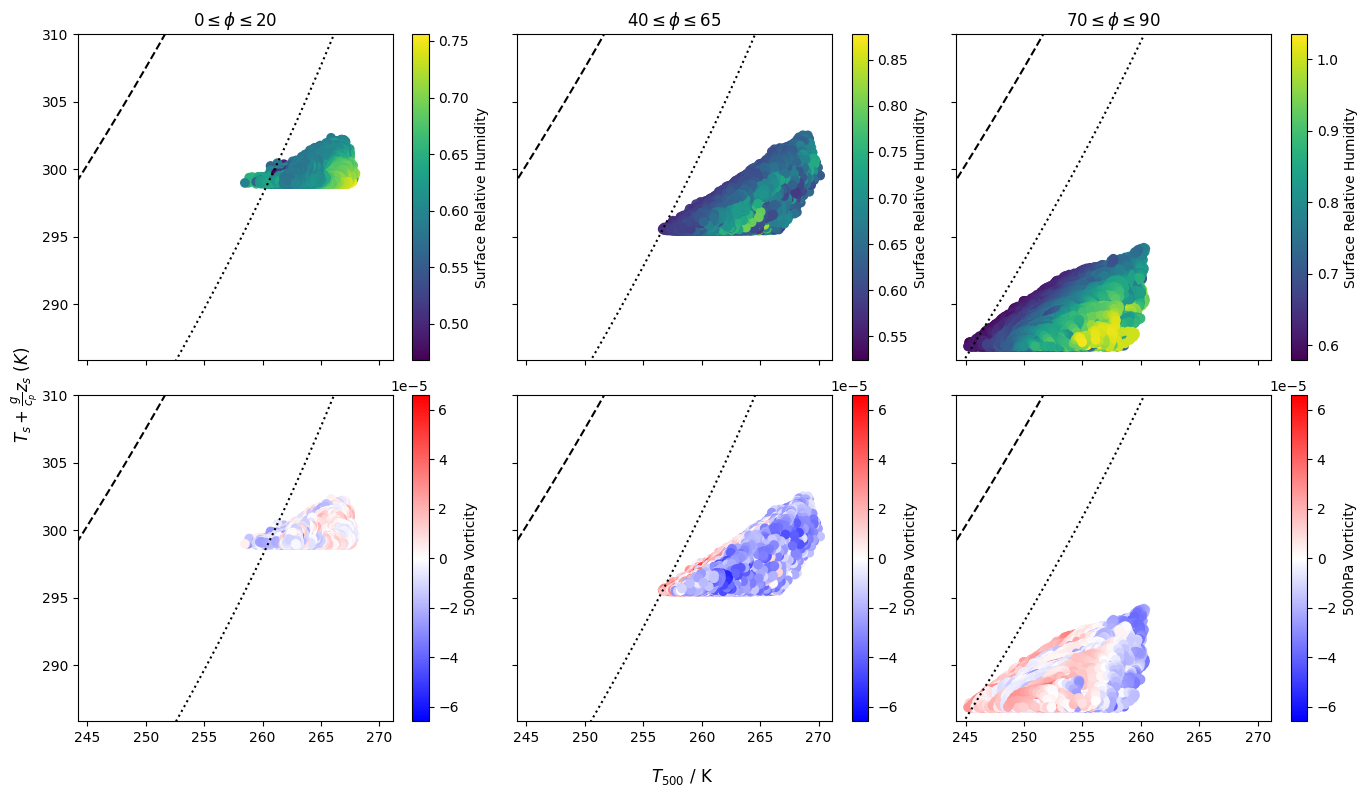

In [9]:
# This cell takes a long time to run!!
vorticity_max = 0.8 * np.max([np.abs(vorticity_lat[i]).max() for i in range(n_lat)])        # so vorticity on same scale on all plots
fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
for i in range(n_lat):
    im = ax[0, i].scatter(ds_lat[i].temp[:, 0], ds_lat[i].temp[:, -1],
                          c=ds_lat[i].sphum[:, -1]/sphum_sat(ds_lat[i].temp[:, -1], pressure_surface * 100))
    plt.colorbar(im, ax=ax[0, i], label='Surface Relative Humidity')
    im = ax[1, i].scatter(ds_lat[i].temp[:, 0], ds_lat[i].temp[:, -1],
                          c=vorticity_lat[i] * np.sign(vorticity_lat[i].lat), cmap='bwr', vmin=-vorticity_max, vmax=vorticity_max)
    plt.colorbar(im, ax=ax[1, i], label=f'{pressure_ft}hPa Vorticity')
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    for k in range(2):
        # Plot upper bound and upper bound taking account of min surface sphum
        ax[k, i].plot(temp_ft_array, temp_upper_bound, color='k', linestyle='--')
        ax[k, i].plot(temp_ft_array, temp_upper_bound - float(L_v/c_p * ds_lat[i].sphum[:, -1].min()), color='k', linestyle=':')
fig.supxlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
fig.supylabel('$T_s + \\frac{g}{c_p}z_s$ ($K$)')
ax[0, 0].set_xlim(np.min([ds_lat[i].temp[:, 0].min() for i in range(n_lat)])-1,
                  np.max([ds_lat[i].temp[:, 0].max() for i in range(n_lat)])+1)
ax[0, 0].set_ylim(quant_thresh.min()-1, 310)
plt.tight_layout()

Below I repeat the above plot but by taking the running average rather than plotting each individual point. This is quicker to run and makes the trends clearer.

In [10]:
n_ft_bins = 30
n_surf_bins = 30
min_data = 10       # only record data if more than this number in the given bin
temp_ft_hist_array = np.linspace(np.min([ds_lat[i].temp[:, 0].min() for i in range(n_lat)])-0.001,
                                 np.max([ds_lat[i].temp[:, 0].max() for i in range(n_lat)])+0.001, n_ft_bins)
temp_surf_hist_array = np.linspace(np.min([ds_lat[i].temp[:, -1].min() for i in range(n_lat)])-0.001,
                                  np.max([ds_lat[i].temp[:, -1].max() for i in range(n_lat)])+0.001, n_surf_bins)
rh_running_mean = np.full((n_lat, n_ft_bins-1, n_surf_bins-1), np.nan)
vorticity_running_mean = np.full((n_lat, n_ft_bins-1, n_surf_bins-1), np.nan)
with tqdm(total= n_lat * (n_ft_bins-1) * (n_surf_bins-1), position=0, leave=True) as pbar:
    for k in range(n_lat):
        rh = ds_lat[k].sphum[:, -1]/sphum_sat(ds_lat[k].temp[:, -1], pressure_surface * 100)
        for i in range(n_ft_bins-1):
            for j in range(n_surf_bins-1):
                keep_ft = np.logical_and(temp_ft_hist_array[i+1] > ds_lat[k].temp[:, 0],
                                         ds_lat[k].temp[:, 0] >= temp_ft_hist_array[i])
                keep_surf = np.logical_and(temp_surf_hist_array[j+1] > ds_lat[k].temp[:, -1],
                                           ds_lat[k].temp[:, -1] >= temp_surf_hist_array[j])
                keep = np.logical_and(keep_ft, keep_surf)
                if np.sum(keep) > min_data:
                    rh_running_mean[k, i, j] = rh.where(keep).mean()
                    vorticity_running_mean[k, i, j] = (vorticity_lat[k] * np.sign(vorticity_lat[k].lat)).where(keep).mean()
                pbar.update(1)

100%|██████████| 2523/2523 [00:46<00:00, 54.40it/s] 


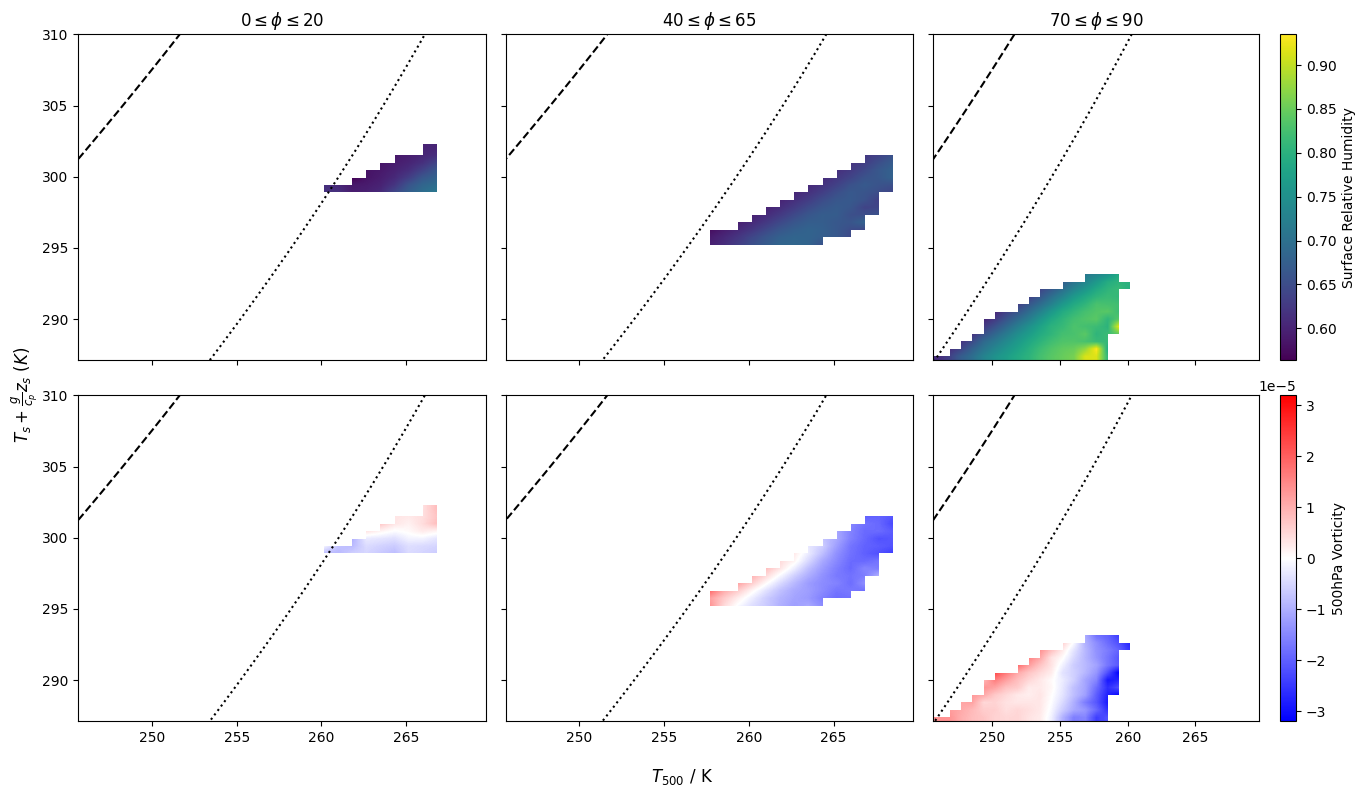

In [11]:
plot_extent = [np.mean(temp_ft_hist_array[:2]), np.mean(temp_ft_hist_array[-2:]),
               np.mean(temp_surf_hist_array[:2]), np.mean(temp_surf_hist_array[-2:])]
rh_lims = [np.nanmin(rh_running_mean), np.nanmax(rh_running_mean)]
vorticity_lims = np.nanmax(np.abs(vorticity_running_mean))
vorticity_lims = [-vorticity_lims, vorticity_lims]
fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
for i in range(n_lat):
    im_rh = ax[0, i].imshow(rh_running_mean[i].T, extent=plot_extent, origin='lower', interpolation='bilinear',
                            vmin=rh_lims[0], vmax=rh_lims[1], aspect='auto')
    im_vort = ax[1, i].imshow(vorticity_running_mean[i].T, extent=plot_extent, origin='lower', interpolation='bilinear',
                              vmin=vorticity_lims[0], vmax=vorticity_lims[1], aspect='auto', cmap='bwr')
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    for k in range(2):
        # Plot upper bound and upper bound taking account of min surface sphum
        ax[k, i].plot(temp_ft_array, temp_upper_bound, color='k', linestyle='--')
        ax[k, i].plot(temp_ft_array, temp_upper_bound - float(L_v/c_p * ds_lat[i].sphum[:, -1].min()), color='k', linestyle=':')
fig.supxlabel(f"$T_{'{'+str(pressure_ft)+'}'}$ / K")
fig.supylabel('$T_s + \\frac{g}{c_p}z_s$ ($K$)')
ax[0, 0].set_xlim(plot_extent[0],
                  plot_extent[1])
ax[0, 0].set_ylim(plot_extent[2], 310)
plt.colorbar(im_rh, ax=ax[0, -1], label='Surface Relative Humidity')
plt.colorbar(im_vort, ax=ax[1, -1], label=f'{pressure_ft}hPa Vorticity')
plt.tight_layout();

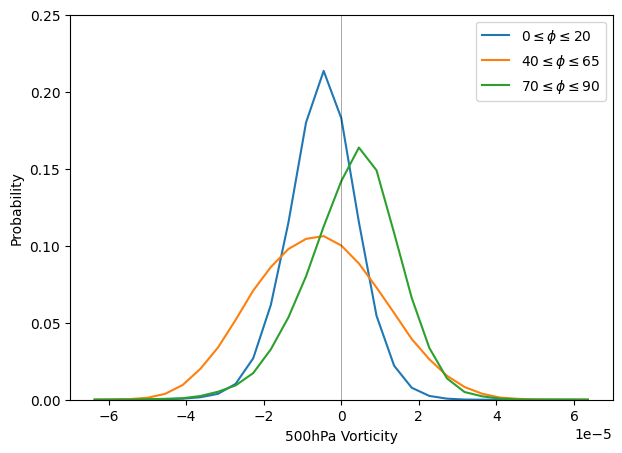

In [12]:
vorticity_bins = np.linspace(-vorticity_max,vorticity_max,30)
fig, ax = plt.subplots(1,1, figsize=(7,5), sharex=True)
for i in range(n_lat):
    hist = np.histogram((vorticity_lat[i]* np.sign(vorticity_lat[i].lat)).to_numpy().flatten(),
                        bins=vorticity_bins)
    ax.plot(np.convolve(vorticity_bins, np.ones(2)/2, mode='valid'), hist[0]/np.sum(hist[0]),
            label=f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
ax.vlines(0, 0.25, 0, color='k', alpha=0.6, linewidth=0.4)
ax.set_ylim(0, 0.25)
ax.legend()
ax.set_xlabel(f'{pressure_ft}hPa Vorticity')
ax.set_ylabel('Probability');

In all three regions, the gap between the scatter plot and the dotted line increases as $T_{500}$ does. This is because at each $T_{500}$ value, the minimum surface relative humidity is about the same but because the temperature increases, the saturation specific humidity increases and thus the surface specific humidity also does. So as $T_{500}$ increases, $q - q_{s, min}$ increases.

### High Latitudes, $70 \leq \phi \leq 90$
From the first plot, it seems that there is a strong trend for the 500hPa temperature to increase with surface relative humidity. This is in contrast to what we expect from Zhang 2023. But for a fixed 500hPa temperature, we see a trend for surface temperature to increase as surface relative humidity decreases, which is what we expect.

The second plot shows that there is a trend for the 500hPa temperature to increase as vorticity decreases i.e. becomes more anticyclonic. This matches what we expect from Zhang 2023.

This is the region that best matches the results in the paper, even though in the paper the mid latitude region is used. Maybe it is because this region includes the widest range of relative humidities.

### Midlatitudes, $40 \leq \phi \leq 65$
The second plot shows that the hottest days are associated with anticyclonic behaviour but the trend with $T_{500}$ is less obvious than at high latitudes.

For fixed $T_{500}$, there seems to be a slight trend for increasing surface temperature as relative humidity decreases, but again not as strong as at high latitudes.

### Tropics, $0 \leq \phi \leq 20$
The vorticity plot doesn't show any recognisable trend.
At the largest $T_{500}$, there seems to be a trend for surface temperature to increase as relative humidity decreases.

### Figure 2 - Time series of annual hottest days
Below, I try to replicate Figure 2 in the paper. For each year in the simulation, I find the hottest day in each region (I actually get 2 values for each year - one in northern hemisphere and one in southern hemisphere, as the hemispheres are equivalent). For each of these days, I keep track of some variables in the 10 days preceeding and 10 days after the hottest day.

The plots then show these variables averaged over all years.

In [13]:
# Get info to compute surface and free troposphere saturated MSE on hottest day for each year considered
# Keep all pressure values hence use ds[0] not ds_use so can plot a time vs pressure heatmap of variables
# Do separately for each hemisphere as should be indentical
n_years = int(len(ds_use.time)/360)         # multiply by 2 as each hemisphere is identical so get max from each
n_days = 10
n_year_days = 360       # number of days in a year
max_info = {'temp': np.zeros((n_lat, n_years, 2, 2*n_days+1, ds[0].pfull.size)),
            'sphum': np.zeros((n_lat, n_years, 2, 2*n_days+1, ds[0].pfull.size)),
            'height': np.zeros((n_lat, n_years, 2, 2*n_days+1, ds[0].pfull.size)),
            'precipitation': np.zeros((n_lat, n_years, 2, 2*n_days+1))}
with tqdm(total= n_lat * n_years * 2, position=0, leave=True) as pbar:
    ds_use_max = ds[0].sel(time=slice(use_time_start, np.inf), drop=True)[var_keep]
    for i in range(n_lat):
        for k in range(2):
            if k == 0:
                # NH first
                ds_max0 = ds_use_max.where((ds_use_max.lat<=lat_max[i]) & (ds_use_max.lat>=lat_min[i]), drop=True)
            else:
                # SH second
                ds_max0 = ds_use_max.where((ds_use_max.lat<=-lat_min[i]) & (ds_use_max.lat>=-lat_max[i]), drop=True)
            for j in range(n_years):
                # Consider each year in turn
                ds_max = ds_max0.sel(time=slice(ds_use.time[j*n_year_days], ds_use.time[(j+1)*n_year_days-1])).load()
                max_ind = ds_max.temp[:, -1].argmax(dim=('time', 'lon', 'lat'))
                max_ind = {key: int(max_ind[key]) for key in max_ind}
                ds_max = ds_max.sel(time=slice(ds_max.time[max_ind['time']-n_days], ds_max.time[max_ind['time']+n_days]))
                ds_max = ds_max.sel(lon=ds_max.lon[max_ind['lon']], lat=ds_max.lat[max_ind['lat']])
                max_info['temp'][i, j, k] = ds_max.temp
                max_info['sphum'][i, j, k] = ds_max.sphum
                max_info['height'][i, j, k] = ds_max.height
                max_info['precipitation'][i, j, k] = ds_max.precipitation
                pbar.update(1)
ft_ind = int(np.where(ds_max.pfull == pressure_ft_actual)[0])       # index of arrays corresponding to free troposphere

100%|██████████| 30/30 [01:39<00:00,  3.30s/it]


In [14]:
max_mse = moist_static_energy(max_info['temp'][:, :, :, :, -1], max_info['sphum'][:, :, :, :, -1], max_info['height'][:, :, :, :, -1])
max_mse_ft = moist_static_energy(max_info['temp'][:, :, :, :, ft_ind],
                                 sphum_sat(max_info['temp'][:, :, :, :, ft_ind], pressure_ft_actual*100),
                                 max_info['height'][:, :, :, :, ft_ind])

# get anomaly of each variable to plot compared to the hottest day
# i.e. hottest day for all of these variables will have a value of 0
max_var_anomaly = [var - np.expand_dims(var[:, :, :, n_days], 3) for var in
                   [max_info['temp'], max_info['precipitation'], max_mse, max_mse_ft]]
max_var_anomaly[3] = max_mse_ft - np.expand_dims(max_mse[:, :, :, n_days], 3)       # make ft mse anomaly relative to max surface mse

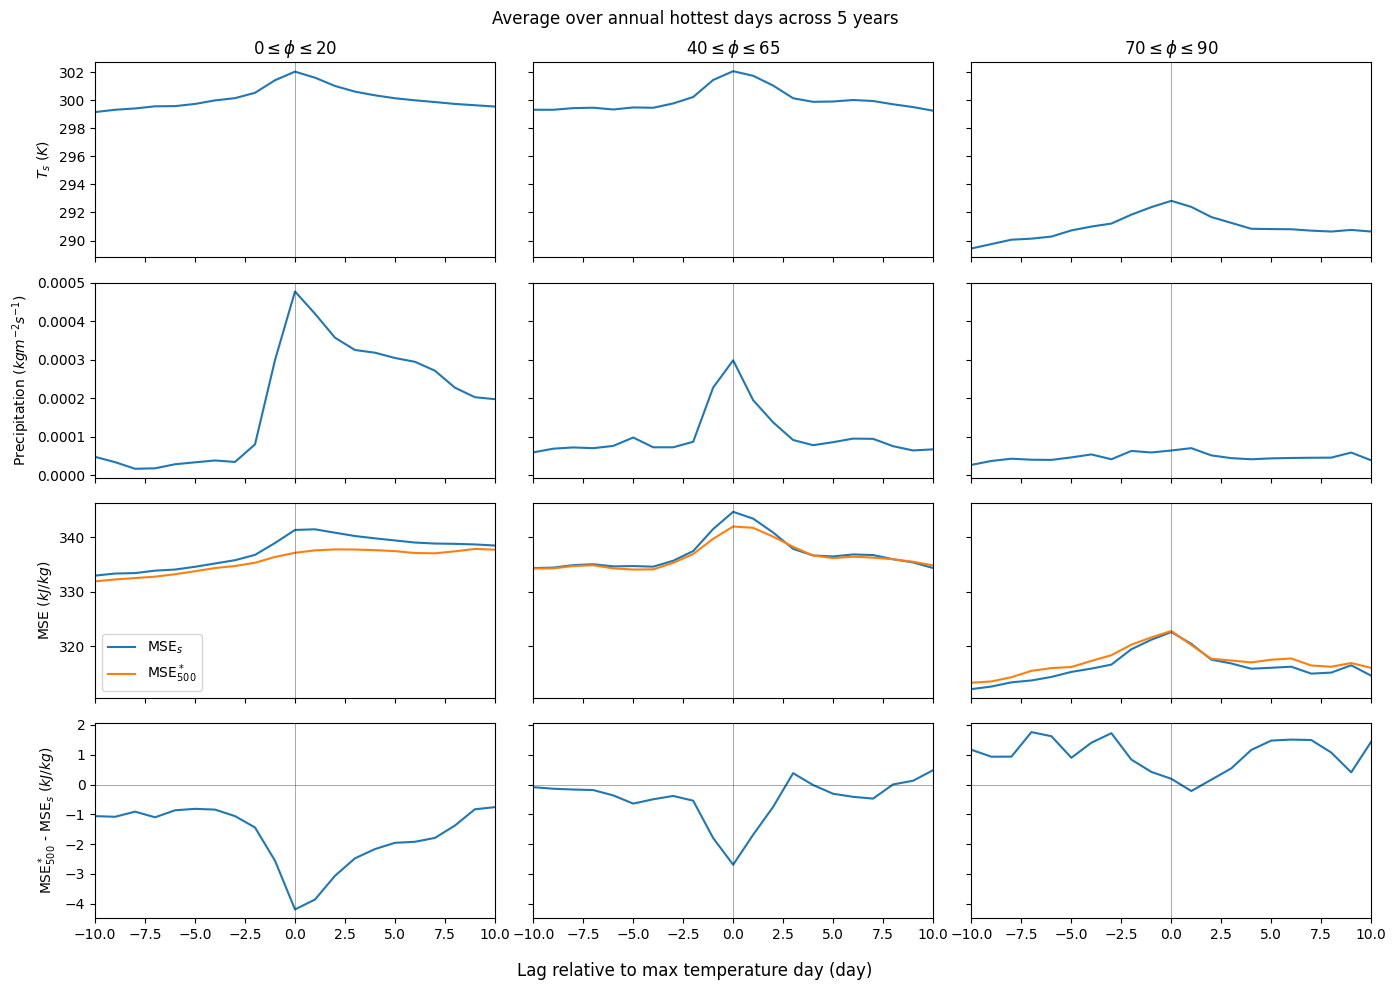

In [15]:
fig, ax = plt.subplots(4, 3, figsize=(14,10), sharex=True, sharey='row')
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_info['temp'][i, :, :, :, -1], axis=(0,1)))
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_info['precipitation'][i, :, :, :], axis=(0,1)))
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse, axis=(1,2))[i], label='MSE$_s$')
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft, axis=(1,2))[i],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$")
    ax[3, i].plot(np.arange(-n_days, n_days+1), np.mean(max_mse_ft-max_mse, axis=(1,2))[i])
    ax[3, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].set_ylabel('$T_s$ ($K$)')
ax[1, 0].set_ylabel('Precipitation ($kgm^{-2}s^{-1}$)')
ax[2, 0].set_ylabel('MSE ($kJ/kg$)')
ax[2, 0].legend()
ax[3, 0].set_ylabel(f"MSE$^*_{'{'+str(pressure_ft)+'}'}$ - MSE$_s$ ($kJ/kg$)")
ax[0, 0].set_xlim(-n_days, n_days)
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Average over annual hottest days across {n_years} years')
plt.tight_layout();

The plot below is the same as that above but before averaging we subtract the value on the hottest day for each year. This way it removes the influence of a particularly anomalous year from the averaging. For the MSE plot, we subtract the surface, $MSE_s$, value on the hottest day from both $MSE_s$ and $MSE^*_{500}$.

So, in the top 3 plots, the y variable of the blue line is always 0 when the x variable is 0. The fourth plot remains the same as in the above plot.

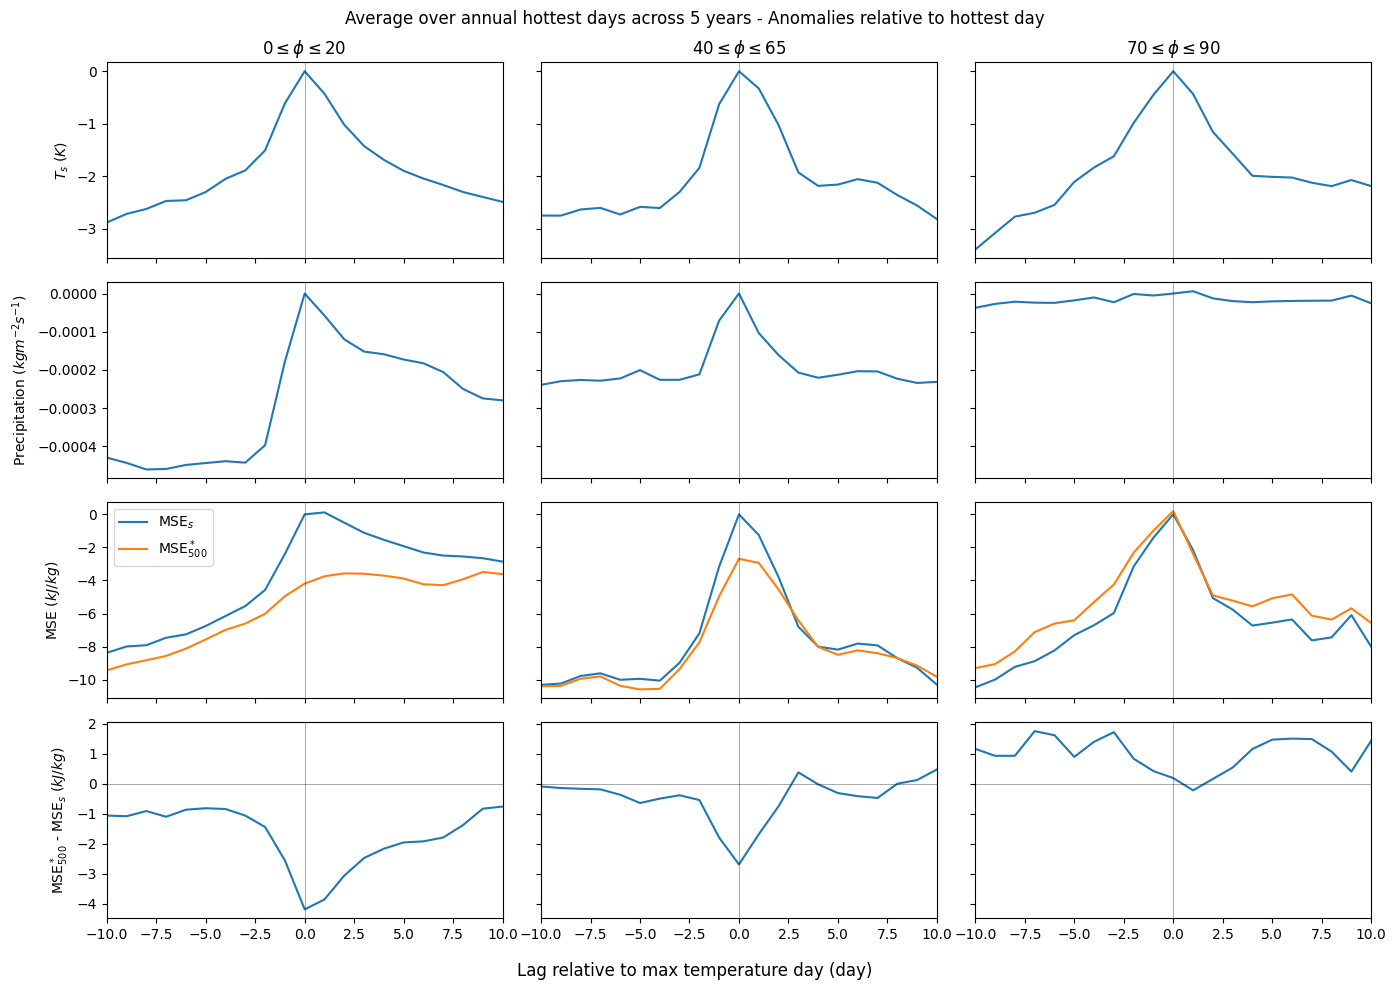

In [16]:
# Repeat above plots but with anomalies
fig, ax = plt.subplots(4, 3, figsize=(14,10), sharex=True, sharey='row')
for i in range(n_lat):
    ax[0, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[0][i, :, :, :, -1], axis=(0,1)))
    ax[1, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[1][i, :, :, :], axis=(0,1)))
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[2], axis=(1,2))[i], label='MSE$_s$')
    ax[2, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[3], axis=(1,2))[i],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$")
    ax[3, i].plot(np.arange(-n_days, n_days+1), np.mean(max_var_anomaly[3]-max_var_anomaly[2], axis=(1,2))[i])
    ax[3, i].hlines(0, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines(0, *ylim, color='k', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)
ax[0, 0].set_ylabel('$T_s$ ($K$)')
ax[1, 0].set_ylabel('Precipitation ($kgm^{-2}s^{-1}$)')
ax[2, 0].set_ylabel('MSE ($kJ/kg$)')
ax[2, 0].legend()
ax[3, 0].set_ylabel(f"MSE$^*_{'{'+str(pressure_ft)+'}'}$ - MSE$_s$ ($kJ/kg$)")
ax[0, 0].set_xlim(-n_days, n_days)
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Average over annual hottest days across {n_years} years - Anomalies relative to hottest day')
plt.tight_layout();

The paper only considers the mid-latitudes (middle row here), and it is expected that the $MSE_{500}^*$ should exceed $MSE_s$ both before and after the hottest day, and they should be equal on the hottest day. The idea being that the surface temperature can only rise as long as the atmosphere remains convectively stable, when $MSE_s$ exceeds $MSE_{500}^*$ it is no longer stable and surface temperature and thus $MSE_s$ must decrease.

We see this trend for the high latitudes (third column) here but not for the other regions.

From the paper, we also expect the precipitation to increase after the hottest day, a trend which we see for the tropics but not for the other regions here. However, in Isca, it is the averaged over quite a large grid so may not be that useful to compare to the more localised value in the paper.

### Figure S2 - Time series of specific heatwave events
This shows the temperature and MSE timeseries for a specific heatwave event in each of the latitude regions. Average temperature for each vertical level over the shown time periods are subtracted to emphasize the anomalies.

It seems that in the tropics and midlatitudes, the free troposphere level is responding to the surface, whereas we would expect it to be the other way around, as is more the case in the high latitudes.

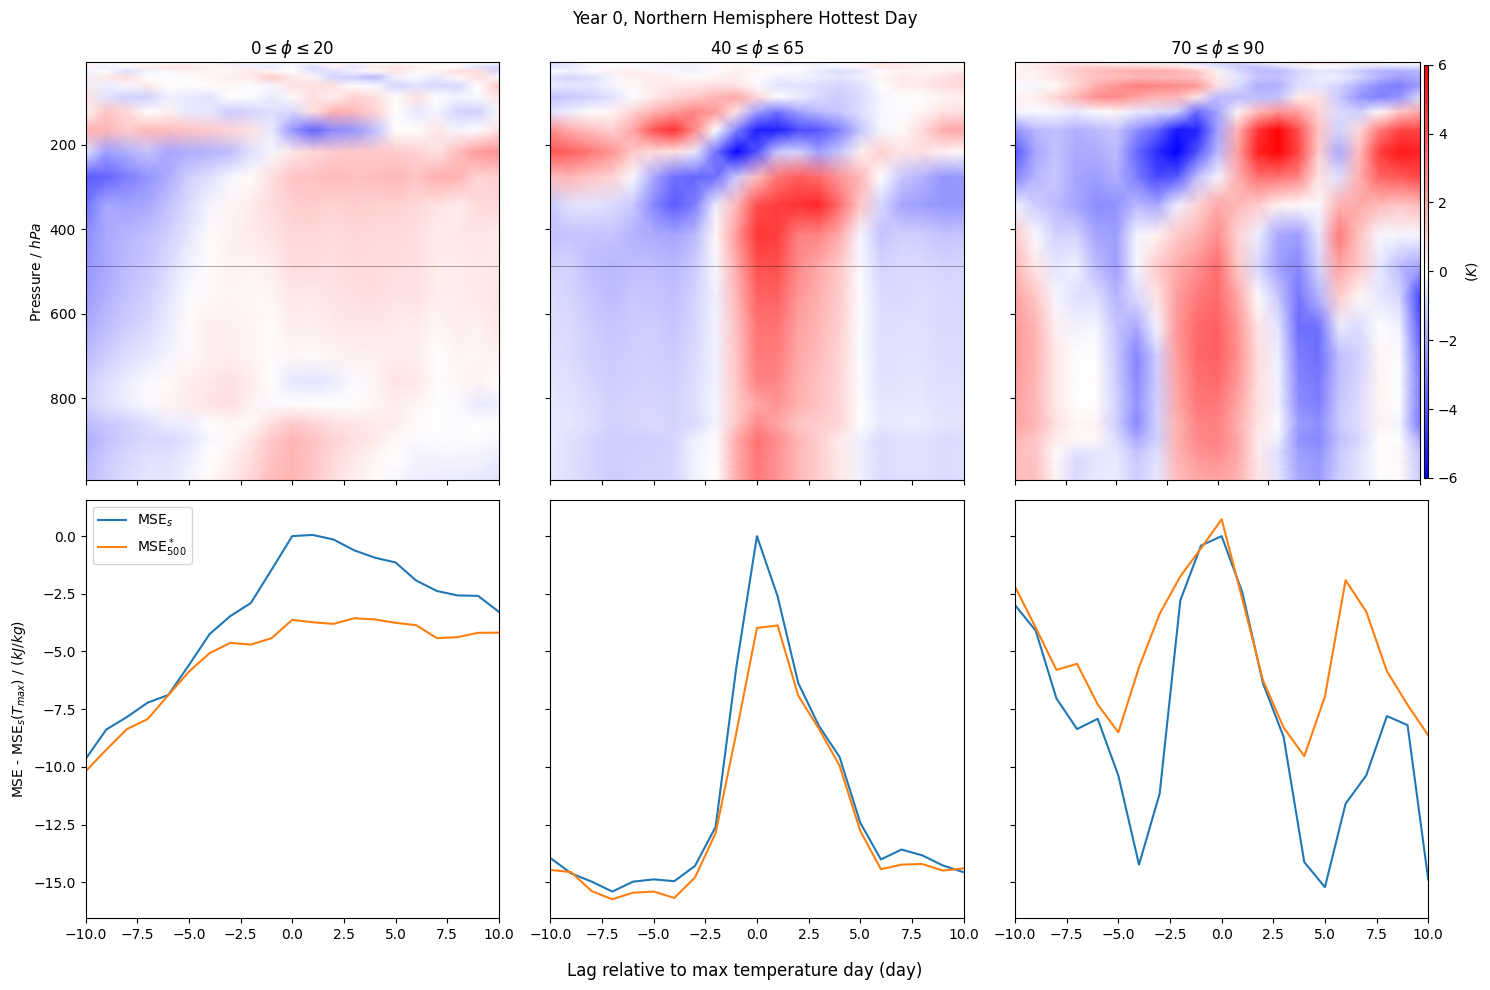

In [52]:
plot_ind = [0, 0]
fig, ax = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey='row')
for i in range(n_lat):
    im_data = max_info['temp'][i, plot_ind[0], plot_ind[1]] - np.mean(max_info['temp'][i, plot_ind[0], plot_ind[1]], axis=0)
    im = ax[0, i].pcolormesh(np.arange(-n_days, n_days+1), ds[0].pfull, im_data.T, cmap='bwr', shading='gouraud', vmin=-6, vmax=6)
    ax[0, i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    ax[0, i].hlines(pressure_ft_actual, -n_days, n_days, color='k', alpha=0.6, linewidth=0.4)
    ax[1, i].plot(np.arange(-n_days, n_days+1), max_var_anomaly[2][i, plot_ind[0], plot_ind[1], :], label='MSE$_s$')
    ax[1, i].plot(np.arange(-n_days, n_days+1), max_var_anomaly[3][i, plot_ind[0], plot_ind[1], :],
                  label=f"MSE$^*_{'{'+str(pressure_ft)+'}'}$")
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, ax=ax[0, i], label='($K$)', aspect=100, pad=0.01, fraction=0.01)
ax[0, 0].invert_yaxis()
ax[0, 0].set_ylabel('Pressure / $hPa$')
ax[1, 0].set_ylabel('MSE - MSE$_s(T_{max})$ / ($kJ/kg$)')
ax[1, 0].legend()
fig.supxlabel('Lag relative to max temperature day (day)')
fig.suptitle(f'Year {plot_ind[0]}, ' + ('Northern Hemisphere' if plot_ind[1]==0 else 'Southern Hemisphere') + ' Hottest Day')
plt.tight_layout();

### Figure S6
Below I try to replicate figure S6 in the supplementary material by plotting the temperature profile on days immediately preceeding the hottest day.

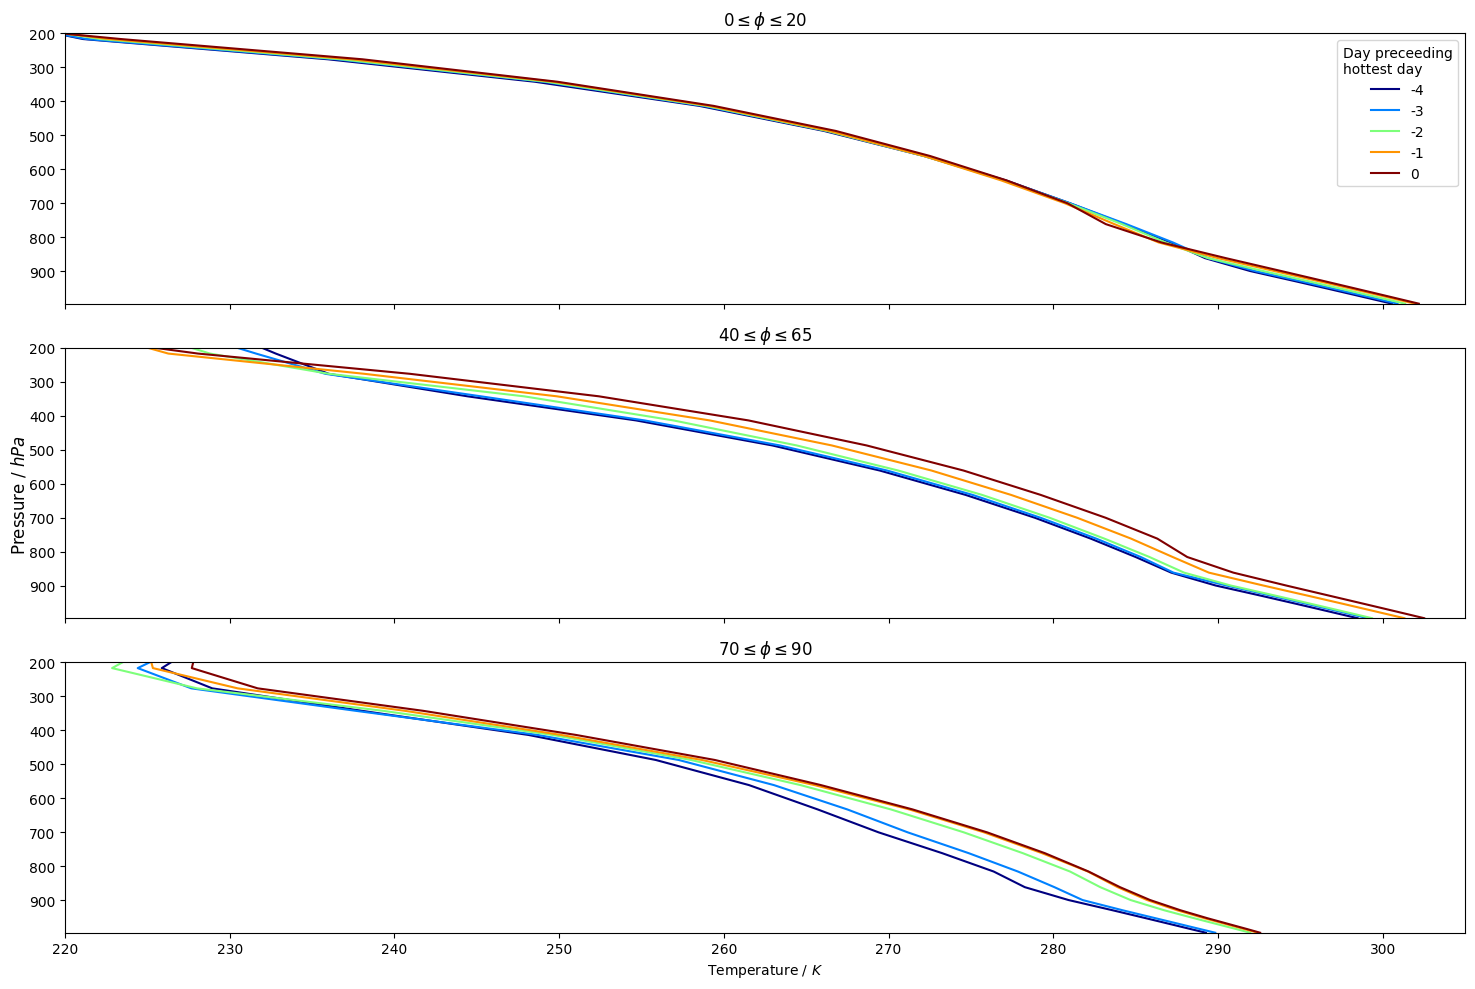

In [61]:
n_days_preceed = 4
warm_colors = plt.cm.jet(np.linspace(0,1,n_days_preceed+1))
fig, ax = plt.subplots(3,1, figsize=(15,10), sharey=True, sharex=True)
for i in range(n_lat):
    ax[i].set_title(f'${lat_min[i]} \leq \\phi \leq {lat_max[i]}$')
    for j in range(n_days-n_days_preceed, n_days+1):
        ax[i].plot(max_info['temp'][i, plot_ind[0], plot_ind[1]][j], ds[0].pfull, label=f'{j-n_days}',
                   color=warm_colors[j-n_days+n_days_preceed])
ax[0].legend(title='Day preceeding\nhottest day')
ax[0].invert_yaxis()
ax[0].set_ylim(pressure_surface, 200)
ax[0].set_xlim(220, 305)
fig.supylabel('Pressure / $hPa$')
ax[-1].set_xlabel('Temperature / $K$')
plt.tight_layout();

#### Focus on Tropics
In the tropics, it appears that all days follow the same profile in the free troposphere, around 500 hPa, but the hottest day changes to a dry adiabat at higher altitude (lower pressure) than the other days and hence when it reaches the surface, it is hotter. This would make sense if on the hottest day, the relative humidity was less, so it has to reach higher altitudes to get saturated - spends more time on the dry adiabat.

However, from the plot below, we see that the pressure of the LCL does not change much on the hottest day from the days preceeding it.

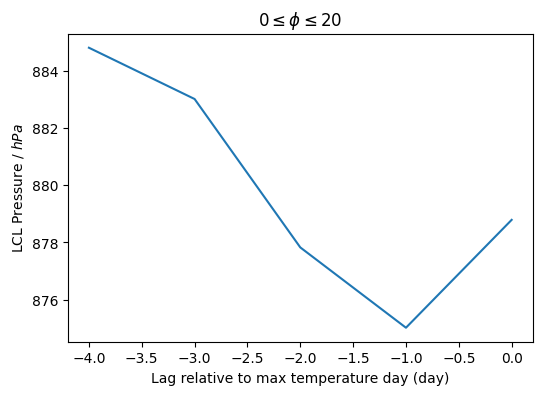

In [217]:
trop_ind = 0
fig, ax = plt.subplots(1,1, figsize=(6,4))

temp_lcl = np.asarray([lcl_temp(max_info['temp'][trop_ind, plot_ind[0], plot_ind[1]][i, -1], pressure_surface * 100,
                                max_info['sphum'][trop_ind, plot_ind[0], plot_ind[1]][i, -1])
                       for i in range(n_days-n_days_preceed, n_days+1)])
# Pressure corresponding to LCL from dry adiabat equation
p_lcl = pressure_surface * (temp_lcl/max_info['temp'][trop_ind, plot_ind[0], plot_ind[1]][n_days-n_days_preceed: n_days+1, -1])**(1/kappa)

ax.plot(np.arange(-n_days_preceed, 1), p_lcl)
ax.set_ylabel('LCL Pressure / $hPa$')
ax.set_title(f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')
ax.set_xlabel('Lag relative to max temperature day (day)');

But clearly, the LCL level indicated in the above plot does not match that of the actual profile as shown below.

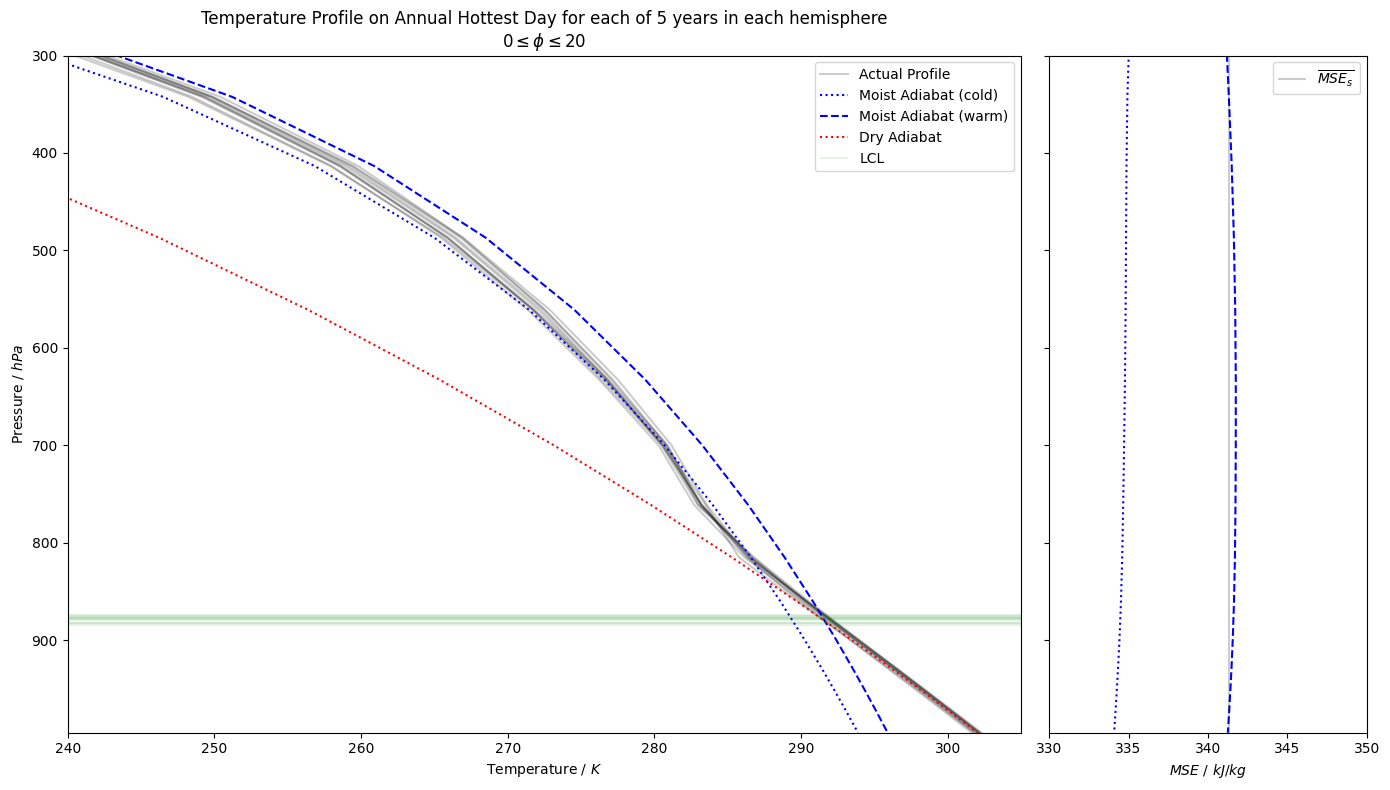

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
p_lcl_all = []
for i in range(max_info['temp'].shape[1]):
    for j in range(max_info['temp'].shape[2]):
        if i + j == 0:
            label = 'Actual Profile'
        else:
            label = None
        ax[0].plot(max_info['temp'][trop_ind, i, j][n_days], ds[0].pfull, label=label,
                color='k', alpha=0.2)
        temp_lcl_single = lcl_temp(max_info['temp'][trop_ind, i, j][n_days, -1], pressure_surface * 100,
                                   max_info['sphum'][trop_ind, i, j][n_days, -1])
        p_lcl_all += [pressure_surface * (temp_lcl_single/max_info['temp'][trop_ind, i, j][n_days, -1])**(1/kappa)]

adiabat_labels = ['Moist Adiabat (cold)', 'Moist Adiabat (warm)', 'Dry Adiabat']
adiabat_linestyles = [':', '--']
# temperature so match convectively neutral profile
if trop_ind == 0:
    adiabat_ft_temp = [265, 268.5]        # tropics
elif trop_ind == 1:
    adiabat_ft_temp = [268.2, 269.8]        # extratropics
elif trop_ind == 2:
    adiabat_ft_temp = [258.5, 258.5]        # high latitudes
adiabat_profiles = [moist_profile(adiabat_ft_temp[i], pressure_ft_actual * 100, ds[0].pfull * 100) for i in range(2)]
for i in range(2):
    ax[0].plot(adiabat_profiles[i], ds[0].pfull, color='b', linestyle=adiabat_linestyles[i], label=adiabat_labels[i])
ax[0].plot(dry_profile(np.mean(max_info['temp'][trop_ind, :, :, n_days, -1]), pressure_surface * 100, ds[0].pfull * 100),
        ds[0].pfull, color='r', linestyle=':', label=adiabat_labels[2])
# for temp_500 in range(245, 285, 10):
#     ax.plot(moist_profile(temp_500, pressure_ft_actual * 100, ds[0].pfull * 100),
#             ds[0].pfull, color='b', linestyle=':', label=adiabat_labels[0])
#     ax.plot(dry_profile(temp_500+2, pressure_ft_actual * 100, ds[0].pfull * 100),
#         ds[0].pfull, color='r', linestyle=':', label=adiabat_labels[1])
#     adiabat_labels = [None, None]
ax[0].hlines(p_lcl_all, 200, 320, color='g', alpha=0.1, label='LCL')
ax[0].legend()
ax[0].invert_yaxis()
ax[0].set_ylim(pressure_surface, 300)
ax[0].set_xlim(240, 305)
ax[0].set_ylabel('Pressure / $hPa$')
ax[0].set_xlabel('Temperature / $K$')
ax[0].set_title(f'Temperature Profile on Annual Hottest Day for each of {n_years} years in each hemisphere\n'
                f'${lat_min[trop_ind]} \leq \\phi \leq {lat_max[trop_ind]}$')

# Sanity check that warmer adiabat has same MSE as surface
for i in range(2):
    ax[1].plot((c_p * adiabat_profiles[i] + L_v * sphum_sat(adiabat_profiles[i], ds[0].pfull * 100) +
              g * np.mean(max_info['height'][trop_ind, :, :, n_days], axis=(0,1)))/1000, ds[0].pfull,
               color='b', linestyle=adiabat_linestyles[i])
ax[1].vlines(np.mean(max_mse[trop_ind, :, :, n_days], axis=(0,1)), 0, 1000, color='k', alpha=0.2, label='$\overline{MSE_s}$')
ax[1].legend()
if trop_ind <= 1:
    ax[1].set_xlim(330, 350)
else:
    ax[1].set_xlim(320, 330)
ax[1].set_xlabel('$MSE$ / $kJ/kg$')
plt.tight_layout();

The temperature profile for these hottest days seem to follow the dry adiabat from the surface up to where it intersects the lower moist adiabat at about 800hPa. Then there is a little bit of CAPE where the blue dotted line is warmer than the black lines between around 780hPa and 700hPa. At pressures lower than this, the environmental profile is warmer than the moist adiabat and so at 500hPa we have the free troposphere saturated MSE (as given by black line) being greater than the surface MSE (as given by the blue dotted line).

However, the LCL computed by Isca is given by the green line. A parcel following the dry adiabat up to this pressure and then following the higher moist adiabat would have surface MSE greater than the free troposphere saturated MSE at 500hPa.

So maybe, rather than using entrainment, we can explain why in Isca the surface MSE is greater than the free troposphere saturated MSE by using this difference between expected LCL and actual LCL.

The plot on the right is just a sanity check that the LCL calculation is correct i.e. that the surface MSE matches the free troposphere saturated MSE on the warmer moist adiabat. This is indeed the case as the blue dashed line matches up well to the grey line. The grey line is the average surface moist static energy over all grey lines in the left plot.